# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

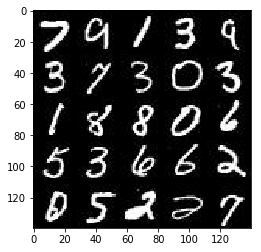

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

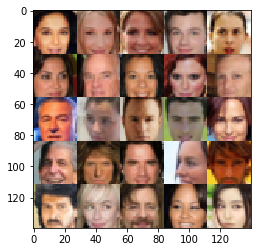

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/usr/local/lib/python3.5/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/usr/local/lib/python3.5/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/usr/local/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/usr/local/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/usr/local/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'F

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(0.2*x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(0.2*bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(0.2*bn3, bn3)
        # 4x4x256
        
        x4 = tf.layers.conv2d(relu3, 512, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(0.2*bn4, bn4)
        # 2x2x512
        
        flat = tf.reshape(relu4, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    reuse = not is_train
    
    with tf.variable_scope('generator', reuse=reuse):
        
        x1 = tf.layers.dense(z, 3*3*1024)
        x1 = tf.reshape(x1, (-1, 3, 3, 1024))
        bn1 = tf.layers.batch_normalization(x1, training=is_train)
        relu1 = tf.maximum(0.2*bn1, bn1)
        # 3x3x1024
        
        x2 = tf.layers.conv2d_transpose(relu1, 512, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=is_train)
        relu2 = tf.maximum(0.2*bn2, bn2)
        # 6x6x512
        
        x3 = tf.layers.conv2d_transpose(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=is_train)
        relu3 = tf.maximum(0.2*bn3, bn3)
        # 12x12x256
        
        x4 = tf.layers.conv2d_transpose(relu3, 128, 5, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=is_train)
        relu4 = tf.maximum(0.2*bn4, bn4)
        # 24x24x128
                
        logits = tf.layers.conv2d_transpose(relu4, out_channel_dim, 5, strides=1, padding='valid')
        # 28x28xout_channel_dim
        
        out = tf.tanh(logits)
        
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                                         labels=tf.ones_like(d_model_real) * 0.9))
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                         labels=tf.zeros_like(d_model_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                                    labels=tf.ones_like(d_model_fake)))
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = 3 if data_image_mode == 'RGB' else 1
    
    i_real, i_z, l_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(i_real, i_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, l_rate, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                batch_images_rescaled = batch_images * 2
                batch_z = np.random.uniform(low=-1, high=1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, 
                             feed_dict={
                                 i_real: batch_images_rescaled, 
                                 i_z: batch_z, 
                                 l_rate: learning_rate
                             })
                
                _ = sess.run(g_opt,
                             feed_dict={
                                 i_z: batch_z,
                                 i_real: batch_images_rescaled, 
                                 l_rate: learning_rate
                             })
                
                _ = sess.run(g_opt,
                             feed_dict={
                                 i_z: batch_z,
                                 i_real: batch_images_rescaled, 
                                 l_rate: learning_rate
                             })
                
                if steps % 10 == 0:
                    train_d_loss = d_loss.eval({i_z: batch_z, i_real: batch_images_rescaled})
                    train_g_loss = g_loss.eval({i_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_d_loss),
                          "Generator Loss: {:.4f}".format(train_g_loss))
                    
                if steps % 100 == 0:
                    show_generator_output(sess, 25, i_z, image_channels, data_image_mode)
            
            show_generator_output(sess, 25, i_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.4269... Generator Loss: 5.3555
Epoch 1/2... Discriminator Loss: 0.6190... Generator Loss: 1.9524
Epoch 1/2... Discriminator Loss: 1.7790... Generator Loss: 2.5753
Epoch 1/2... Discriminator Loss: 1.3219... Generator Loss: 0.9390
Epoch 1/2... Discriminator Loss: 1.3455... Generator Loss: 1.6443
Epoch 1/2... Discriminator Loss: 0.6931... Generator Loss: 1.7314
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.8386
Epoch 1/2... Discriminator Loss: 1.1685... Generator Loss: 0.6818
Epoch 1/2... Discriminator Loss: 1.0326... Generator Loss: 0.9241
Epoch 1/2... Discriminator Loss: 1.3500... Generator Loss: 0.6131


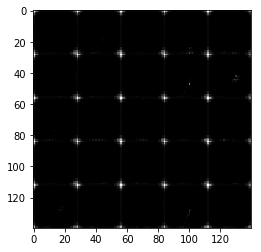

Epoch 1/2... Discriminator Loss: 1.2727... Generator Loss: 0.8314
Epoch 1/2... Discriminator Loss: 1.7133... Generator Loss: 0.7137
Epoch 1/2... Discriminator Loss: 1.5366... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.7721... Generator Loss: 0.6113
Epoch 1/2... Discriminator Loss: 1.5011... Generator Loss: 0.7500
Epoch 1/2... Discriminator Loss: 1.5048... Generator Loss: 0.8623
Epoch 1/2... Discriminator Loss: 1.3657... Generator Loss: 0.8103
Epoch 1/2... Discriminator Loss: 1.3317... Generator Loss: 0.7975
Epoch 1/2... Discriminator Loss: 1.4885... Generator Loss: 0.6140
Epoch 1/2... Discriminator Loss: 1.3457... Generator Loss: 0.7301


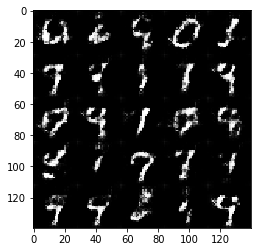

Epoch 1/2... Discriminator Loss: 1.4698... Generator Loss: 0.6972
Epoch 1/2... Discriminator Loss: 1.4526... Generator Loss: 0.7487
Epoch 1/2... Discriminator Loss: 1.5112... Generator Loss: 0.6457
Epoch 1/2... Discriminator Loss: 1.3975... Generator Loss: 0.7331
Epoch 1/2... Discriminator Loss: 1.4419... Generator Loss: 0.6645
Epoch 1/2... Discriminator Loss: 1.3995... Generator Loss: 0.7849
Epoch 1/2... Discriminator Loss: 1.4900... Generator Loss: 0.5651
Epoch 1/2... Discriminator Loss: 1.5057... Generator Loss: 0.6971
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 0.6655
Epoch 1/2... Discriminator Loss: 1.4059... Generator Loss: 0.8026


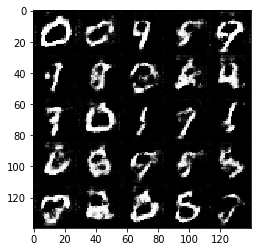

Epoch 1/2... Discriminator Loss: 1.4549... Generator Loss: 0.5754
Epoch 1/2... Discriminator Loss: 1.4209... Generator Loss: 0.7431
Epoch 1/2... Discriminator Loss: 1.5261... Generator Loss: 0.6181
Epoch 1/2... Discriminator Loss: 1.3839... Generator Loss: 0.7772
Epoch 1/2... Discriminator Loss: 1.4536... Generator Loss: 0.6805
Epoch 1/2... Discriminator Loss: 1.3621... Generator Loss: 0.7999
Epoch 1/2... Discriminator Loss: 1.4503... Generator Loss: 0.6698
Epoch 1/2... Discriminator Loss: 1.4008... Generator Loss: 0.8451
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.6509
Epoch 1/2... Discriminator Loss: 1.3822... Generator Loss: 0.6729


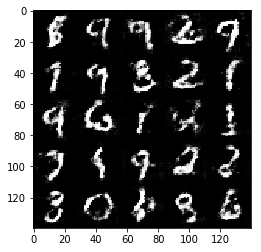

Epoch 1/2... Discriminator Loss: 1.4261... Generator Loss: 0.6363
Epoch 1/2... Discriminator Loss: 1.4717... Generator Loss: 0.6607
Epoch 1/2... Discriminator Loss: 1.4232... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.5875... Generator Loss: 0.9721
Epoch 1/2... Discriminator Loss: 1.4583... Generator Loss: 0.7103
Epoch 1/2... Discriminator Loss: 1.4862... Generator Loss: 0.5879
Epoch 1/2... Discriminator Loss: 1.4005... Generator Loss: 0.6479
Epoch 1/2... Discriminator Loss: 1.4220... Generator Loss: 0.6492
Epoch 1/2... Discriminator Loss: 1.3988... Generator Loss: 0.8250
Epoch 1/2... Discriminator Loss: 1.4482... Generator Loss: 0.5385


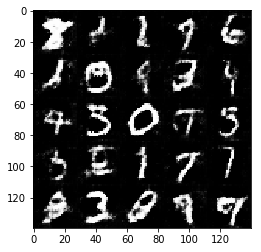

Epoch 1/2... Discriminator Loss: 1.5029... Generator Loss: 0.7021
Epoch 1/2... Discriminator Loss: 1.4410... Generator Loss: 0.6127
Epoch 1/2... Discriminator Loss: 1.4597... Generator Loss: 0.7130
Epoch 1/2... Discriminator Loss: 1.5032... Generator Loss: 0.4951
Epoch 1/2... Discriminator Loss: 1.4942... Generator Loss: 0.5530
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 0.5885
Epoch 1/2... Discriminator Loss: 1.4158... Generator Loss: 0.6846
Epoch 1/2... Discriminator Loss: 1.6197... Generator Loss: 0.3937
Epoch 1/2... Discriminator Loss: 1.3535... Generator Loss: 0.7061
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.6716


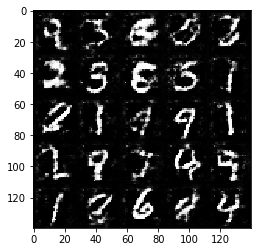

Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.8255
Epoch 1/2... Discriminator Loss: 1.3731... Generator Loss: 0.7144
Epoch 1/2... Discriminator Loss: 1.4332... Generator Loss: 0.8639
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.5244
Epoch 1/2... Discriminator Loss: 1.4939... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 1.4486... Generator Loss: 0.5332
Epoch 1/2... Discriminator Loss: 1.5311... Generator Loss: 0.5891
Epoch 1/2... Discriminator Loss: 1.4172... Generator Loss: 0.6134
Epoch 1/2... Discriminator Loss: 1.5050... Generator Loss: 0.5779
Epoch 1/2... Discriminator Loss: 1.4327... Generator Loss: 0.6963


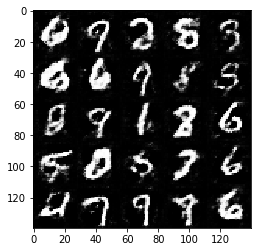

Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.6324
Epoch 1/2... Discriminator Loss: 1.4776... Generator Loss: 0.6763
Epoch 1/2... Discriminator Loss: 1.3634... Generator Loss: 0.7517
Epoch 1/2... Discriminator Loss: 1.5805... Generator Loss: 0.4584
Epoch 1/2... Discriminator Loss: 1.4494... Generator Loss: 0.6027
Epoch 1/2... Discriminator Loss: 1.3954... Generator Loss: 0.9170
Epoch 1/2... Discriminator Loss: 1.5109... Generator Loss: 0.5239
Epoch 1/2... Discriminator Loss: 1.3814... Generator Loss: 0.8288
Epoch 1/2... Discriminator Loss: 1.4752... Generator Loss: 0.7943
Epoch 1/2... Discriminator Loss: 1.5860... Generator Loss: 0.4623


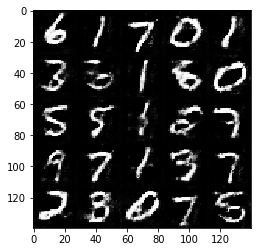

Epoch 1/2... Discriminator Loss: 1.4064... Generator Loss: 0.6631
Epoch 1/2... Discriminator Loss: 1.4757... Generator Loss: 1.0231
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.6128
Epoch 1/2... Discriminator Loss: 1.4892... Generator Loss: 0.7191
Epoch 1/2... Discriminator Loss: 1.6368... Generator Loss: 0.3682
Epoch 1/2... Discriminator Loss: 1.4228... Generator Loss: 0.6298
Epoch 1/2... Discriminator Loss: 1.4041... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.6899... Generator Loss: 0.3543
Epoch 1/2... Discriminator Loss: 1.5997... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.5337... Generator Loss: 0.6333


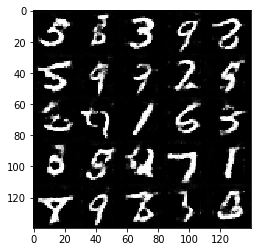

Epoch 1/2... Discriminator Loss: 1.5981... Generator Loss: 0.4049
Epoch 1/2... Discriminator Loss: 1.5369... Generator Loss: 0.4865
Epoch 1/2... Discriminator Loss: 2.6161... Generator Loss: 1.9761


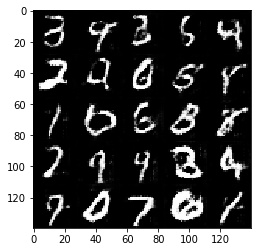

Epoch 2/2... Discriminator Loss: 1.4119... Generator Loss: 0.5644
Epoch 2/2... Discriminator Loss: 1.3536... Generator Loss: 0.7654
Epoch 2/2... Discriminator Loss: 1.3962... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.4271... Generator Loss: 0.4966
Epoch 2/2... Discriminator Loss: 1.4106... Generator Loss: 0.5813
Epoch 2/2... Discriminator Loss: 1.3901... Generator Loss: 0.5493
Epoch 2/2... Discriminator Loss: 1.4395... Generator Loss: 0.5405


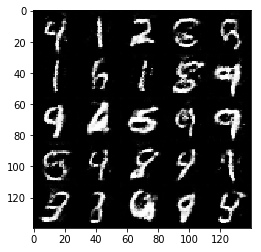

Epoch 2/2... Discriminator Loss: 1.4588... Generator Loss: 0.5577
Epoch 2/2... Discriminator Loss: 1.3491... Generator Loss: 0.6514
Epoch 2/2... Discriminator Loss: 1.4363... Generator Loss: 0.4878
Epoch 2/2... Discriminator Loss: 1.4083... Generator Loss: 0.6011
Epoch 2/2... Discriminator Loss: 1.4290... Generator Loss: 0.5922
Epoch 2/2... Discriminator Loss: 1.5982... Generator Loss: 0.4088
Epoch 2/2... Discriminator Loss: 1.6956... Generator Loss: 0.4108
Epoch 2/2... Discriminator Loss: 1.5394... Generator Loss: 1.3006
Epoch 2/2... Discriminator Loss: 1.4189... Generator Loss: 0.6414
Epoch 2/2... Discriminator Loss: 1.5635... Generator Loss: 0.7184


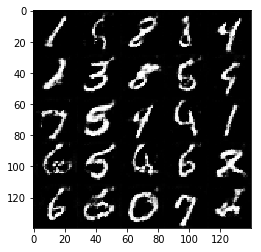

Epoch 2/2... Discriminator Loss: 1.6187... Generator Loss: 0.3963
Epoch 2/2... Discriminator Loss: 1.6538... Generator Loss: 0.4068
Epoch 2/2... Discriminator Loss: 1.4564... Generator Loss: 0.4988
Epoch 2/2... Discriminator Loss: 1.4100... Generator Loss: 0.5193
Epoch 2/2... Discriminator Loss: 1.5338... Generator Loss: 0.4649
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 0.7704
Epoch 2/2... Discriminator Loss: 1.6227... Generator Loss: 0.4275
Epoch 2/2... Discriminator Loss: 1.5187... Generator Loss: 0.9420
Epoch 2/2... Discriminator Loss: 1.5637... Generator Loss: 0.4326
Epoch 2/2... Discriminator Loss: 1.3414... Generator Loss: 0.6435


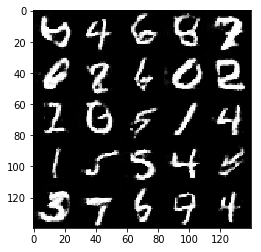

Epoch 2/2... Discriminator Loss: 1.1408... Generator Loss: 0.9762
Epoch 2/2... Discriminator Loss: 1.5601... Generator Loss: 0.4123
Epoch 2/2... Discriminator Loss: 1.6603... Generator Loss: 0.3767
Epoch 2/2... Discriminator Loss: 1.4597... Generator Loss: 0.5501
Epoch 2/2... Discriminator Loss: 1.5632... Generator Loss: 0.4332
Epoch 2/2... Discriminator Loss: 1.4698... Generator Loss: 0.4551
Epoch 2/2... Discriminator Loss: 1.5650... Generator Loss: 0.4838
Epoch 2/2... Discriminator Loss: 1.4895... Generator Loss: 0.5388
Epoch 2/2... Discriminator Loss: 1.6097... Generator Loss: 0.4506
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.6751


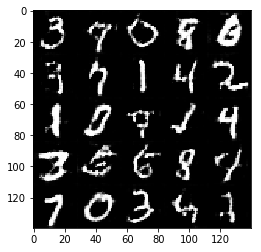

Epoch 2/2... Discriminator Loss: 1.5872... Generator Loss: 0.4472
Epoch 2/2... Discriminator Loss: 1.5523... Generator Loss: 0.4091
Epoch 2/2... Discriminator Loss: 1.2427... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 1.5084... Generator Loss: 0.4783
Epoch 2/2... Discriminator Loss: 1.4282... Generator Loss: 0.6420
Epoch 2/2... Discriminator Loss: 1.2903... Generator Loss: 0.6144
Epoch 2/2... Discriminator Loss: 1.4823... Generator Loss: 0.4478
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.4927
Epoch 2/2... Discriminator Loss: 1.5802... Generator Loss: 0.6258
Epoch 2/2... Discriminator Loss: 1.5774... Generator Loss: 0.6171


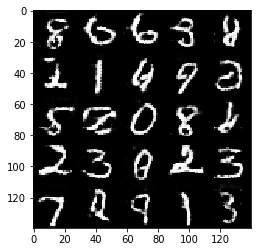

Epoch 2/2... Discriminator Loss: 1.2514... Generator Loss: 0.6890
Epoch 2/2... Discriminator Loss: 1.5932... Generator Loss: 0.3890
Epoch 2/2... Discriminator Loss: 1.4664... Generator Loss: 0.4849
Epoch 2/2... Discriminator Loss: 1.3812... Generator Loss: 0.5029
Epoch 2/2... Discriminator Loss: 1.2167... Generator Loss: 0.8785
Epoch 2/2... Discriminator Loss: 1.4068... Generator Loss: 0.5609
Epoch 2/2... Discriminator Loss: 1.5987... Generator Loss: 0.3851
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 1.5090... Generator Loss: 1.2681
Epoch 2/2... Discriminator Loss: 1.3500... Generator Loss: 0.7322


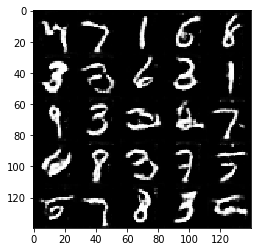

Epoch 2/2... Discriminator Loss: 1.5312... Generator Loss: 0.5708
Epoch 2/2... Discriminator Loss: 1.7168... Generator Loss: 0.3273
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 0.6454
Epoch 2/2... Discriminator Loss: 1.3826... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 1.3381... Generator Loss: 0.5474
Epoch 2/2... Discriminator Loss: 1.4847... Generator Loss: 0.4431
Epoch 2/2... Discriminator Loss: 1.3606... Generator Loss: 0.5987
Epoch 2/2... Discriminator Loss: 1.5341... Generator Loss: 0.4595
Epoch 2/2... Discriminator Loss: 1.5816... Generator Loss: 0.6296
Epoch 2/2... Discriminator Loss: 1.4546... Generator Loss: 0.4750


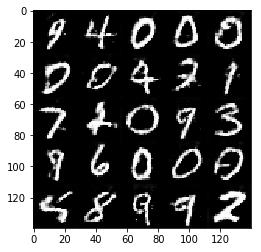

Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 0.7243
Epoch 2/2... Discriminator Loss: 1.4509... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 1.0215... Generator Loss: 1.1121
Epoch 2/2... Discriminator Loss: 1.2783... Generator Loss: 1.3110
Epoch 2/2... Discriminator Loss: 1.5349... Generator Loss: 0.4367
Epoch 2/2... Discriminator Loss: 1.3016... Generator Loss: 0.5758
Epoch 2/2... Discriminator Loss: 1.3534... Generator Loss: 0.6929
Epoch 2/2... Discriminator Loss: 1.6813... Generator Loss: 0.3918
Epoch 2/2... Discriminator Loss: 1.7879... Generator Loss: 0.3040
Epoch 2/2... Discriminator Loss: 1.9500... Generator Loss: 0.2499


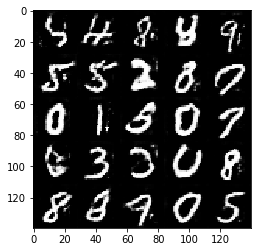

Epoch 2/2... Discriminator Loss: 1.3934... Generator Loss: 0.6834
Epoch 2/2... Discriminator Loss: 1.6009... Generator Loss: 0.3882
Epoch 2/2... Discriminator Loss: 1.4635... Generator Loss: 0.4693
Epoch 2/2... Discriminator Loss: 1.1810... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 1.3252... Generator Loss: 0.7253
Epoch 2/2... Discriminator Loss: 1.1469... Generator Loss: 0.8187
Epoch 2/2... Discriminator Loss: 1.5148... Generator Loss: 0.4581
Epoch 2/2... Discriminator Loss: 1.7880... Generator Loss: 0.3056
Epoch 2/2... Discriminator Loss: 1.3630... Generator Loss: 0.6210
Epoch 2/2... Discriminator Loss: 1.6965... Generator Loss: 0.3642


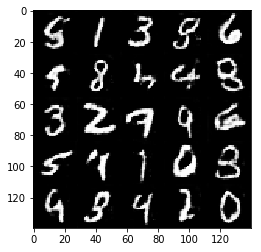

Epoch 2/2... Discriminator Loss: 1.5247... Generator Loss: 0.4627
Epoch 2/2... Discriminator Loss: 1.2309... Generator Loss: 0.8270
Epoch 2/2... Discriminator Loss: 1.4298... Generator Loss: 0.9930
Epoch 2/2... Discriminator Loss: 1.2230... Generator Loss: 0.8150
Epoch 2/2... Discriminator Loss: 1.4571... Generator Loss: 1.7343
Epoch 2/2... Discriminator Loss: 1.8336... Generator Loss: 0.3229
Epoch 2/2... Discriminator Loss: 1.2732... Generator Loss: 0.6859


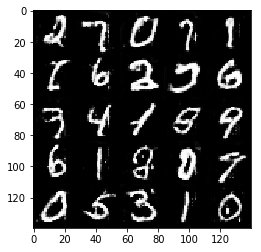

In [13]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.8549... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 0.8983... Generator Loss: 1.1534
Epoch 1/1... Discriminator Loss: 1.3912... Generator Loss: 0.5162
Epoch 1/1... Discriminator Loss: 1.7910... Generator Loss: 0.2892
Epoch 1/1... Discriminator Loss: 0.5194... Generator Loss: 2.6736
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.2420
Epoch 1/1... Discriminator Loss: 1.0096... Generator Loss: 2.4539
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.9435
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.8795
Epoch 1/1... Discriminator Loss: 1.3330... Generator Loss: 0.8386


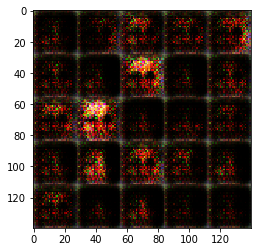

Epoch 1/1... Discriminator Loss: 1.6210... Generator Loss: 0.7164
Epoch 1/1... Discriminator Loss: 1.5786... Generator Loss: 0.8970
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 2.1945... Generator Loss: 0.2967
Epoch 1/1... Discriminator Loss: 1.7273... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.8692... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.7409... Generator Loss: 0.5955
Epoch 1/1... Discriminator Loss: 1.5914... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.6651... Generator Loss: 0.5565


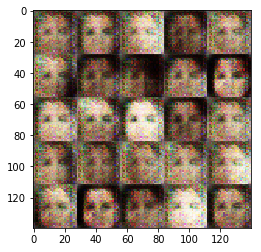

Epoch 1/1... Discriminator Loss: 1.4058... Generator Loss: 0.7611
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.6968
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6379
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.5858
Epoch 1/1... Discriminator Loss: 1.4669... Generator Loss: 0.7175
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3855... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.5987... Generator Loss: 0.5399
Epoch 1/1... Discriminator Loss: 1.8893... Generator Loss: 0.3778


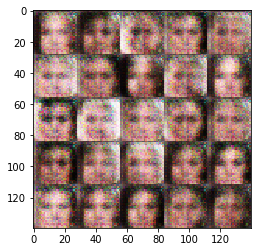

Epoch 1/1... Discriminator Loss: 1.5269... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3463... Generator Loss: 0.8906
Epoch 1/1... Discriminator Loss: 1.6820... Generator Loss: 0.5513
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.6826
Epoch 1/1... Discriminator Loss: 1.9213... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.9038... Generator Loss: 0.4785
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.8725... Generator Loss: 0.5523
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.7784... Generator Loss: 0.5282


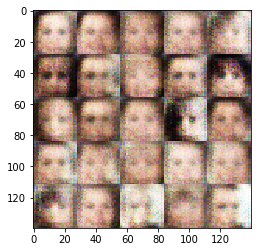

Epoch 1/1... Discriminator Loss: 1.5769... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.6092... Generator Loss: 0.5863
Epoch 1/1... Discriminator Loss: 1.6208... Generator Loss: 0.6663
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7051
Epoch 1/1... Discriminator Loss: 1.4862... Generator Loss: 0.6493
Epoch 1/1... Discriminator Loss: 1.4695... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.6787
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.7473


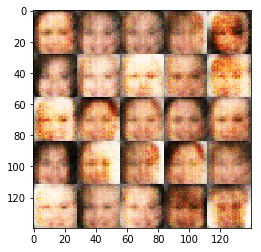

Epoch 1/1... Discriminator Loss: 1.6244... Generator Loss: 0.5813
Epoch 1/1... Discriminator Loss: 1.5425... Generator Loss: 0.6908
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3826... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.4554... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7065
Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7708
Epoch 1/1... Discriminator Loss: 1.5582... Generator Loss: 0.6687
Epoch 1/1... Discriminator Loss: 1.5266... Generator Loss: 0.6893


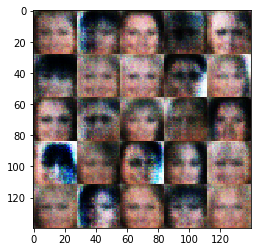

Epoch 1/1... Discriminator Loss: 1.4482... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7452
Epoch 1/1... Discriminator Loss: 1.4895... Generator Loss: 0.7167
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.6432
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.5111... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3767... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7557
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7502


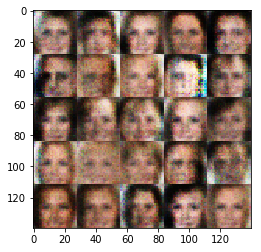

Epoch 1/1... Discriminator Loss: 1.5032... Generator Loss: 0.6864
Epoch 1/1... Discriminator Loss: 1.4932... Generator Loss: 0.6956
Epoch 1/1... Discriminator Loss: 1.4736... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.7338
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7580
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4574... Generator Loss: 0.6971
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4390... Generator Loss: 0.7204


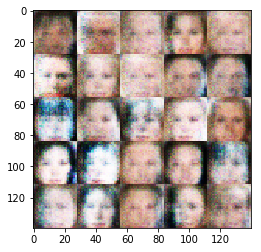

Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.7576
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.5000... Generator Loss: 0.6809
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.7308
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7009
Epoch 1/1... Discriminator Loss: 1.4725... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4407... Generator Loss: 0.7209
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4224... Generator Loss: 0.7408


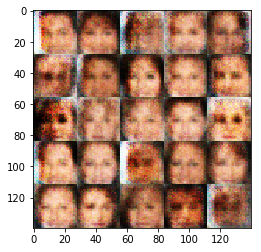

Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4420... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4739... Generator Loss: 0.6992
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7484
Epoch 1/1... Discriminator Loss: 1.4659... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7214
Epoch 1/1... Discriminator Loss: 1.4557... Generator Loss: 0.7143
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7341
Epoch 1/1... Discriminator Loss: 1.4214... Generator Loss: 0.7506


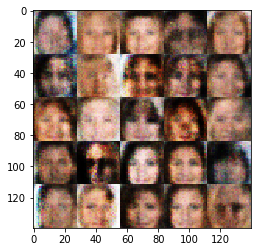

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.4328... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7323
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7378
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7207
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.7660
Epoch 1/1... Discriminator Loss: 1.4345... Generator Loss: 0.7479


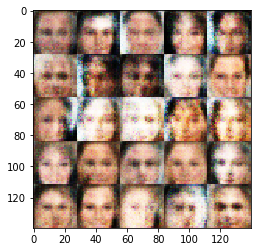

Epoch 1/1... Discriminator Loss: 1.4402... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.4243... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7498
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7531
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4563... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.7394
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7401
Epoch 1/1... Discriminator Loss: 1.4275... Generator Loss: 0.7401


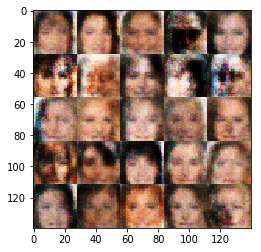

Epoch 1/1... Discriminator Loss: 1.4274... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.3724... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4542... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.4120... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.7520
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7524
Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7523


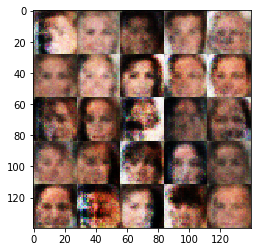

Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7174
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.4368... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7602
Epoch 1/1... Discriminator Loss: 1.4196... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7530


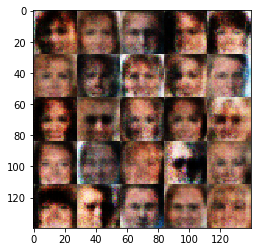

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.7569


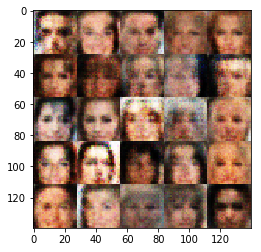

Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.7415
Epoch 1/1... Discriminator Loss: 1.4358... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4127... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.4043... Generator Loss: 0.7700


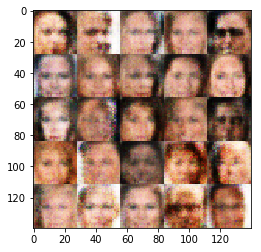

Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.7283
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.4431... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.3854... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7540
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4017... Generator Loss: 0.7830


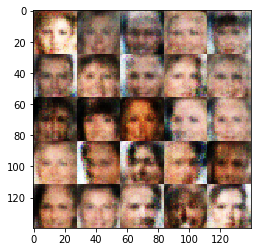

Epoch 1/1... Discriminator Loss: 1.4152... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7550
Epoch 1/1... Discriminator Loss: 1.4050... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4079... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4077... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.3969... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7610


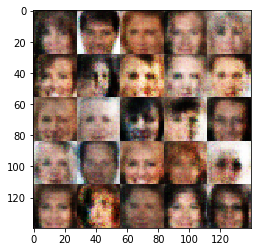

Epoch 1/1... Discriminator Loss: 1.3925... Generator Loss: 0.7762
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7607
Epoch 1/1... Discriminator Loss: 1.4201... Generator Loss: 0.7659
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7618
Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.7649
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7607


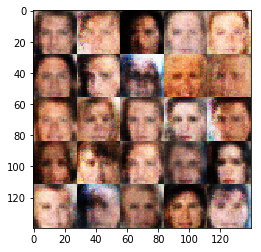

Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7802
Epoch 1/1... Discriminator Loss: 1.4061... Generator Loss: 0.7517
Epoch 1/1... Discriminator Loss: 1.4177... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3938... Generator Loss: 0.7798
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7573
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7719
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7782


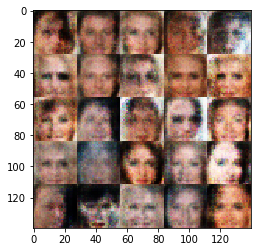

Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7566
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3928... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7571
Epoch 1/1... Discriminator Loss: 1.4109... Generator Loss: 0.7616
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7727
Epoch 1/1... Discriminator Loss: 1.4001... Generator Loss: 0.7798


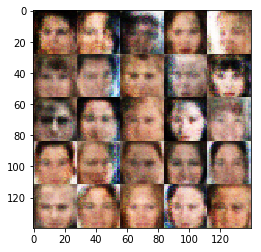

Epoch 1/1... Discriminator Loss: 1.4029... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.3872... Generator Loss: 0.7821
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7687
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4095... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7552
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.4062... Generator Loss: 0.7657


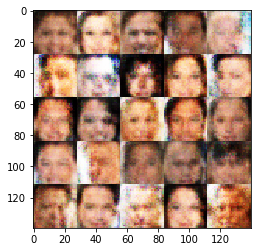

Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7617
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7648
Epoch 1/1... Discriminator Loss: 1.3975... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.3961... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4049... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.4027... Generator Loss: 0.7758
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.7579


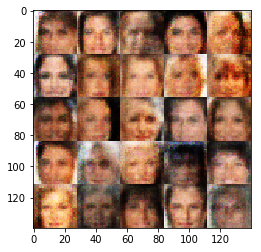

Epoch 1/1... Discriminator Loss: 1.4044... Generator Loss: 0.7625
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7697
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.7765
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.3953... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.7878


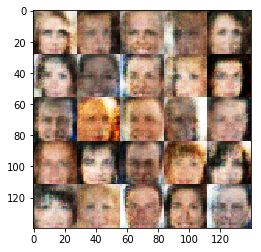

Epoch 1/1... Discriminator Loss: 1.4046... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7744
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7641
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7847
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7737


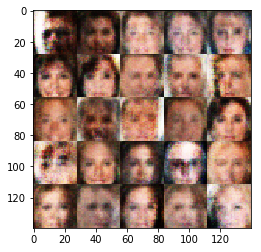

Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7669
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7915
Epoch 1/1... Discriminator Loss: 1.4010... Generator Loss: 0.7577
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.4158... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7790
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.4022... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.4000... Generator Loss: 0.7720
Epoch 1/1... Discriminator Loss: 1.3933... Generator Loss: 0.7894


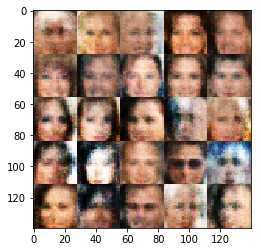

Epoch 1/1... Discriminator Loss: 1.4072... Generator Loss: 0.7594
Epoch 1/1... Discriminator Loss: 1.3984... Generator Loss: 0.7676
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.3978... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7832
Epoch 1/1... Discriminator Loss: 1.4057... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3850... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.3829... Generator Loss: 0.7849
Epoch 1/1... Discriminator Loss: 1.3811... Generator Loss: 0.7999


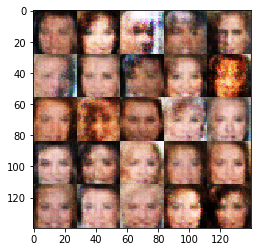

Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.7767
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.7945
Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.7795
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7784
Epoch 1/1... Discriminator Loss: 1.4056... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3977... Generator Loss: 0.7848


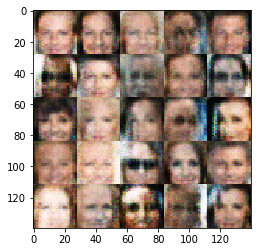

Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3962... Generator Loss: 0.7834
Epoch 1/1... Discriminator Loss: 1.3867... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.3994... Generator Loss: 0.7843
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.7703
Epoch 1/1... Discriminator Loss: 1.4067... Generator Loss: 0.7693
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.7883


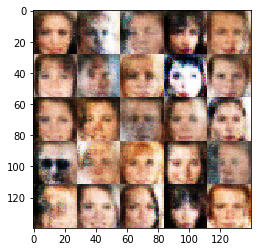

Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.4008... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.3836... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.3992... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.4023... Generator Loss: 0.7719


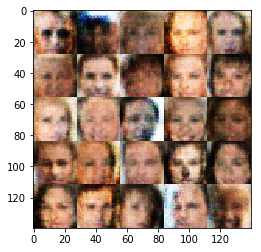

Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.3934... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7827
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.3906... Generator Loss: 0.7895
Epoch 1/1... Discriminator Loss: 1.3915... Generator Loss: 0.7704
Epoch 1/1... Discriminator Loss: 1.3930... Generator Loss: 0.7754
Epoch 1/1... Discriminator Loss: 1.3990... Generator Loss: 0.7786
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7719


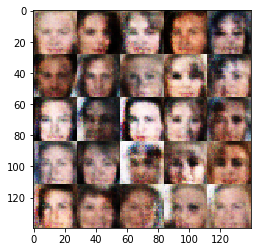

Epoch 1/1... Discriminator Loss: 1.4019... Generator Loss: 0.7796
Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.3919... Generator Loss: 0.7817


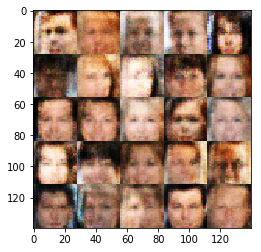

In [14]:
batch_size = 64
z_dim = 200
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.